### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install jiwer
!pip install einops addict easydict

### Unsloth

Let's prepare the OCR model to our local first

In [2]:
from huggingface_hub import snapshot_download
snapshot_download("unsloth/DeepSeek-OCR", local_dir = "deepseek_ocr")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

assets/fig1.png:   0%|          | 0.00/396k [00:00<?, ?B/s]

assets/show1.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

assets/show2.jpg:   0%|          | 0.00/216k [00:00<?, ?B/s]

assets/show3.jpg:   0%|          | 0.00/247k [00:00<?, ?B/s]

assets/show4.jpg:   0%|          | 0.00/269k [00:00<?, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

README-checkpoint.md: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

deepencoder.py: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

'/content/deepseek_ocr'

In [3]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from transformers import AutoModel
import os
os.environ["UNSLOTH_WARN_UNINITIALIZED"] = '0'
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.

model, tokenizer = FastVisionModel.from_pretrained(
    "./deepseek_ocr",
    load_in_4bit = True, # Use 4bit to reduce memory use
    auto_model = AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.9: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at ./deepseek_ocr and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data Preparation

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Project2_OCR/Dataset.zip'
extract_path = '/content/dataset_vietnamese'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Đã giải nén dữ liệu vào: {extract_path}")

Đã giải nén dữ liệu vào: /content/dataset_vietnamese


### Evaluate Deepseek-OCR Baseline Performance on Vietnamese Transcription

In [6]:
import json

def load_vietnamese_test_set(base_path):
    test_samples = []
    if not os.path.exists(base_path):
        print(f"Lỗi: Không tìm thấy đường dẫn {base_path}")
        return []
    for subfolder in os.listdir(base_path):
        subfolder_path = os.path.join(base_path, subfolder)
        if os.path.isdir(subfolder_path):
            label_file = os.path.join(subfolder_path, 'label.json')
            if os.path.exists(label_file):
                with open(label_file, 'r', encoding='utf-8') as f:
                    labels = json.load(f)
                    for img_name, text in labels.items():
                        img_path = os.path.join(subfolder_path, img_name)
                        if os.path.exists(img_path):
                            test_samples.append({"image_path": img_path, "ground_truth": text})
    return test_samples

test_base_path = '/content/dataset_vietnamese/Dataset/test_data'
test_set = load_vietnamese_test_set(test_base_path)
print(f"Tổng số mẫu test tìm thấy: {len(test_set)}")

Tổng số mẫu test tìm thấy: 400


In [7]:
import inspect

old_infer = model.infer

def patched_infer(*args, **kwargs):
    import io, contextlib
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        old_infer(*args, **kwargs)
    text = buf.getvalue()

    # lọc bỏ log rác, giữ text OCR
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    ocr_lines = [l for l in lines if not l.startswith(("BASE:", "PATCHES", "image:", "other:", "%", "="))]
    return " ".join(ocr_lines)

model.infer = patched_infer

In [8]:
import json # Thêm thư viện json ở đầu cell
from jiwer import cer, wer
from tqdm import tqdm
import os
import unicodedata
import numpy as np

def evaluate_baseline(model, tokenizer, test_samples, output_json_path="baseline_ocr_results.json"):

    detailed_results_list = []

    dummy_output = "/content/temp_results"
    if not os.path.exists(dummy_output):
        os.makedirs(dummy_output)

    prompt = "<image>\nFree OCR. "

    print("Đang chạy đánh giá Baseline và thu thập kết quả chi tiết...")
    for index, sample in enumerate(tqdm(test_samples)):
        res = model.infer(
            tokenizer,
            prompt=prompt,
            image_file=sample['image_path'],
            output_path=dummy_output,
            base_size=1024,
            image_size=640,
            crop_mode=True,
            save_results=False
        )

        prediction_text = unicodedata.normalize('NFC', res) if res is not None else ""
        gt_text = unicodedata.normalize('NFC', sample['ground_truth'])

        clean_prediction = prediction_text.strip().lower()
        clean_gt = gt_text.strip().lower()

        cer_for_sample = cer(clean_gt, clean_prediction) if clean_gt else 1.0

        sample_result = {
            "index": index,
            "ground_truth": clean_gt,
            "prediction": clean_prediction,
            "cer": cer_for_sample
        }

        detailed_results_list.append(sample_result)

    print(f"\n💾 Đang lưu kết quả OCR chi tiết vào file: {output_json_path}")
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(detailed_results_list, f, ensure_ascii=False, indent=4)
    print("Lưu thành công!")

    all_gts = [item['ground_truth'] for item in detailed_results_list]
    all_preds = [item['prediction'] for item in detailed_results_list]
    individual_cers = [item['cer'] for item in detailed_results_list]

    summary_metrics = {
        'total_cer': cer(all_gts, all_preds),
        'total_wer': wer(all_gts, all_preds),
        'mean_cer': np.mean(individual_cers),
        'median_cer': np.median(individual_cers),
        'min_cer': np.min(individual_cers),
        'max_cer': np.max(individual_cers),
        'predictions': all_preds
    }

    return summary_metrics

In [9]:
# Gọi hàm đã được sửa đổi, giờ nó trả về một dictionary
baseline_metrics = evaluate_baseline(model, tokenizer, test_set)

print(f"\n--- 📊 KẾT QUẢ BASELINE ---")

print("\n--- Thống kê CER trên từng mẫu ---")
print(f"Mean CER (Trung bình): {baseline_metrics.get('mean_cer', 0) * 100:.2f}%")
print(f"Median CER (Trung vị): {baseline_metrics.get('median_cer', 0) * 100:.2f}%")
print(f"Min CER (Thấp nhất): {baseline_metrics.get('min_cer', 0) * 100:.2f}%")
print(f"Max CER (Cao nhất): {baseline_metrics.get('max_cer', 0) * 100:.2f}%")

print("\n--- Chỉ số trên toàn bộ tập dữ liệu ---")
print(f"Total Character Error Rate (CER): {baseline_metrics.get('total_cer', 0) * 100:.2f}%")
print(f"Total Word Error Rate (WER): {baseline_metrics.get('total_wer', 0) * 100:.2f}%")

Đang chạy đánh giá Baseline và thu thập kết quả chi tiết...


100%|██████████| 400/400 [32:45<00:00,  4.91s/it]


💾 Đang lưu kết quả OCR chi tiết vào file: baseline_ocr_results.json
Lưu thành công!

--- 📊 KẾT QUẢ BASELINE ---

--- Thống kê CER trên từng mẫu ---
Mean CER (Trung bình): 32.47%
Median CER (Trung vị): 28.11%
Min CER (Thấp nhất): 0.00%
Max CER (Cao nhất): 131.11%

--- Chỉ số trên toàn bộ tập dữ liệu ---
Total Character Error Rate (CER): 32.21%
Total Word Error Rate (WER): 66.74%


# Finetune Deepseek-OCR !

In [10]:
model = FastVisionModel.get_peft_model(
    model,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model` require gradients


### Data Preparation


In [11]:
import os
import json
from PIL import Image

instruction = "<image>\nFree OCR. "

def load_and_convert_vietnamese_dataset(base_path):
    converted_samples = []
    for subfolder in os.listdir(base_path):
        subfolder_path = os.path.join(base_path, subfolder)
        if os.path.isdir(subfolder_path):
            label_file = os.path.join(subfolder_path, 'label.json')
            if os.path.exists(label_file):
                with open(label_file, 'r', encoding='utf-8') as f:
                    labels = json.load(f)
                    for img_name, text in labels.items():
                        img_path = os.path.join(subfolder_path, img_name)
                        if os.path.exists(img_path):
                            image = Image.open(img_path).convert("RGB")

                            sample = {
                                "messages": [
                                    {
                                        "role": "<|User|>",
                                        "content": instruction,
                                        "images": [image]
                                    },
                                    {
                                        "role": "<|Assistant|>",
                                        "content": text
                                    }
                                ]
                            }
                            converted_samples.append(sample)
    return converted_samples

In [12]:
train_base_path = '/content/dataset_vietnamese/Dataset/train_data'
train_dataset = load_and_convert_vietnamese_dataset(train_base_path)

val_base_path = '/content/dataset_vietnamese/Dataset/validation_data'
val_dataset = load_and_convert_vietnamese_dataset(val_base_path)

print(f"Tổng số mẫu train: {len(train_dataset)}")
print(f"Tổng số mẫu validation: {len(val_dataset)}")

Tổng số mẫu train: 3200
Tổng số mẫu validation: 150


In [13]:
# @title Create datacollator

import torch
import math
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple
from PIL import Image, ImageOps
from torch.nn.utils.rnn import pad_sequence
import io

from deepseek_ocr.modeling_deepseekocr import (
    format_messages,
    text_encode,
    BasicImageTransform,
    dynamic_preprocess,
)

@dataclass
class DeepSeekOCRDataCollator:
    """
    Args:
        tokenizer: Tokenizer
        model: Model
        image_size: Size for image patches (default: 640)
        base_size: Size for global view (default: 1024)
        crop_mode: Whether to use dynamic cropping for large images
        train_on_responses_only: If True, only train on assistant responses (mask user prompts)
    """
    tokenizer: Any
    model: Any
    image_size: int = 640
    base_size: int = 1024
    crop_mode: bool = True
    image_token_id: int = 128815
    train_on_responses_only: bool = True

    def __init__(
        self,
        tokenizer,
        model,
        image_size: int = 640,
        base_size: int = 1024,
        crop_mode: bool = True,
        train_on_responses_only: bool = True,
    ):
        self.tokenizer = tokenizer
        self.model = model
        self.image_size = image_size
        self.base_size = base_size
        self.crop_mode = crop_mode
        self.image_token_id = 128815
        self.dtype = model.dtype  # Get dtype from model
        self.train_on_responses_only = train_on_responses_only

        self.image_transform = BasicImageTransform(
            mean=(0.5, 0.5, 0.5),
            std=(0.5, 0.5, 0.5),
            normalize=True
        )
        self.patch_size = 16
        self.downsample_ratio = 4

        # Get BOS token ID from tokenizer
        if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id is not None:
            self.bos_id = tokenizer.bos_token_id
        else:
            self.bos_id = 0
            print(f"Warning: tokenizer has no bos_token_id, using default: {self.bos_id}")

    def deserialize_image(self, image_data) -> Image.Image:
        """Convert image data (bytes dict or PIL Image) to PIL Image in RGB mode"""
        if isinstance(image_data, Image.Image):
            return image_data.convert("RGB")
        elif isinstance(image_data, dict) and 'bytes' in image_data:
            image_bytes = image_data['bytes']
            image = Image.open(io.BytesIO(image_bytes))
            return image.convert("RGB")
        else:
            raise ValueError(f"Unsupported image format: {type(image_data)}")

    def calculate_image_token_count(self, image: Image.Image, crop_ratio: Tuple[int, int]) -> int:
        """Calculate the number of tokens this image will generate"""
        num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
        num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

        width_crop_num, height_crop_num = crop_ratio

        if self.crop_mode:
            img_tokens = num_queries_base * num_queries_base + 1
            if width_crop_num > 1 or height_crop_num > 1:
                img_tokens += (num_queries * width_crop_num + 1) * (num_queries * height_crop_num)
        else:
            img_tokens = num_queries * num_queries + 1

        return img_tokens

    def process_image(self, image: Image.Image) -> Tuple[List, List, List, List, Tuple[int, int]]:
        """
        Process a single image based on crop_mode and size thresholds

        Returns:
            Tuple of (images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio)
        """
        images_list = []
        images_crop_list = []
        images_spatial_crop = []

        if self.crop_mode:
            # Determine crop ratio based on image size
            if image.size[0] <= 640 and image.size[1] <= 640:
                crop_ratio = (1, 1)
                images_crop_raw = []
            else:
                images_crop_raw, crop_ratio = dynamic_preprocess(
                    image, min_num=2, max_num=9,
                    image_size=self.image_size, use_thumbnail=False
                )

            # Process global view with padding
            global_view = ImageOps.pad(
                image, (self.base_size, self.base_size),
                color=tuple(int(x * 255) for x in self.image_transform.mean)
            )
            images_list.append(self.image_transform(global_view).to(self.dtype))

            width_crop_num, height_crop_num = crop_ratio
            images_spatial_crop.append([width_crop_num, height_crop_num])

            # Process local views (crops) if applicable
            if width_crop_num > 1 or height_crop_num > 1:
                for crop_img in images_crop_raw:
                    images_crop_list.append(
                        self.image_transform(crop_img).to(self.dtype)
                    )

            # Calculate image tokens
            num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
            num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

            tokenized_image = ([self.image_token_id] * num_queries_base + [self.image_token_id]) * num_queries_base
            tokenized_image += [self.image_token_id]

            if width_crop_num > 1 or height_crop_num > 1:
                tokenized_image += ([self.image_token_id] * (num_queries * width_crop_num) + [self.image_token_id]) * (
                    num_queries * height_crop_num)

        else:  # crop_mode = False
            crop_ratio = (1, 1)
            images_spatial_crop.append([1, 1])

            # For smaller base sizes, resize; for larger, pad
            if self.base_size <= 640:
                resized_image = image.resize((self.base_size, self.base_size), Image.LANCZOS)
                images_list.append(self.image_transform(resized_image).to(self.dtype))
            else:
                global_view = ImageOps.pad(
                    image, (self.base_size, self.base_size),
                    color=tuple(int(x * 255) for x in self.image_transform.mean)
                )
                images_list.append(self.image_transform(global_view).to(self.dtype))

            num_queries = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
            tokenized_image = ([self.image_token_id] * num_queries + [self.image_token_id]) * num_queries
            tokenized_image += [self.image_token_id]

        return images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio

    def process_single_sample(self, messages: List[Dict]) -> Dict[str, Any]:
            """
            Process a single conversation into model inputs.
            """

            # --- 1. Setup ---
            images = []
            for message in messages:
                if "images" in message and message["images"]:
                    for img_data in message["images"]:
                        if img_data is not None:
                            pil_image = self.deserialize_image(img_data)
                            images.append(pil_image)

            if not images:
                raise ValueError("No images found in sample. Please ensure all samples contain images.")

            tokenized_str = []
            images_seq_mask = []
            images_list, images_crop_list, images_spatial_crop = [], [], []

            prompt_token_count = -1 # Index to start training
            assistant_started = False
            image_idx = 0

            # Add BOS token at the very beginning
            tokenized_str.append(self.bos_id)
            images_seq_mask.append(False)

            for message in messages:
                role = message["role"]
                content = message["content"]

                # Check if this is the assistant's turn
                if role == "<|Assistant|>":
                    if not assistant_started:
                        # This is the split point. All tokens added *so far*
                        # are part of the prompt.
                        prompt_token_count = len(tokenized_str)
                        assistant_started = True

                    # Append the EOS token string to the *end* of assistant content
                    content = f"{content.strip()} {self.tokenizer.eos_token}"

                # Split this message's content by the image token
                text_splits = content.split('<image>')

                for i, text_sep in enumerate(text_splits):
                    # Tokenize the text part
                    tokenized_sep = text_encode(self.tokenizer, text_sep, bos=False, eos=False)
                    tokenized_str.extend(tokenized_sep)
                    images_seq_mask.extend([False] * len(tokenized_sep))

                    # If this text is followed by an <image> tag
                    if i < len(text_splits) - 1:
                        if image_idx >= len(images):
                            raise ValueError(
                                f"Data mismatch: Found '<image>' token but no corresponding image."
                            )

                        # Process the image
                        image = images[image_idx]
                        img_list, crop_list, spatial_crop, tok_img, _ = self.process_image(image)

                        images_list.extend(img_list)
                        images_crop_list.extend(crop_list)
                        images_spatial_crop.extend(spatial_crop)

                        # Add image placeholder tokens
                        tokenized_str.extend(tok_img)
                        images_seq_mask.extend([True] * len(tok_img))

                        image_idx += 1 # Move to the next image

            # --- 3. Validation and Final Prep ---
            if image_idx != len(images):
                raise ValueError(
                    f"Data mismatch: Found {len(images)} images but only {image_idx} '<image>' tokens were used."
                )

            # If we never found an assistant message, we're in a weird state
            # (e.g., user-only prompt). We mask everything.
            if not assistant_started:
                print("Warning: No assistant message found in sample. Masking all tokens.")
                prompt_token_count = len(tokenized_str)

            # Prepare image tensors
            images_ori = torch.stack(images_list, dim=0)
            images_spatial_crop_tensor = torch.tensor(images_spatial_crop, dtype=torch.long)

            if images_crop_list:
                images_crop = torch.stack(images_crop_list, dim=0)
            else:
                images_crop = torch.zeros((1, 3, self.base_size, self.base_size), dtype=self.dtype)

            return {
                "input_ids": torch.tensor(tokenized_str, dtype=torch.long),
                "images_seq_mask": torch.tensor(images_seq_mask, dtype=torch.bool),
                "images_ori": images_ori,
                "images_crop": images_crop,
                "images_spatial_crop": images_spatial_crop_tensor,
                "prompt_token_count": prompt_token_count, # This is now accurate
            }

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Collate batch of samples"""
        batch_data = []

        # Process each sample
        for feature in features:
            try:
                processed = self.process_single_sample(feature['messages'])
                batch_data.append(processed)
            except Exception as e:
                print(f"Error processing sample: {e}")
                continue

        if not batch_data:
            raise ValueError("No valid samples in batch")

        # Extract lists
        input_ids_list = [item['input_ids'] for item in batch_data]
        images_seq_mask_list = [item['images_seq_mask'] for item in batch_data]
        prompt_token_counts = [item['prompt_token_count'] for item in batch_data]

        # Pad sequences
        input_ids = pad_sequence(input_ids_list, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        images_seq_mask = pad_sequence(images_seq_mask_list, batch_first=True, padding_value=False)

        # Create labels
        labels = input_ids.clone()

        # Mask padding tokens
        labels[labels == self.tokenizer.pad_token_id] = -100

        # Mask image tokens (model shouldn't predict these)
        labels[images_seq_mask] = -100

        # Mask user prompt tokens when train_on_responses_only=True (only train on assistant responses)
        if self.train_on_responses_only:
            for idx, prompt_count in enumerate(prompt_token_counts):
                if prompt_count > 0:
                    labels[idx, :prompt_count] = -100

        # Create attention mask
        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()

        # Prepare images batch (list of tuples)
        images_batch = []
        for item in batch_data:
            images_batch.append((item['images_crop'], item['images_ori']))

        # Stack spatial crop info
        images_spatial_crop = torch.cat([item['images_spatial_crop'] for item in batch_data], dim=0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "images": images_batch,
            "images_seq_mask": images_seq_mask,
            "images_spatial_crop": images_spatial_crop,
        }

### Train the model

In [14]:
from transformers import Trainer, TrainingArguments
from unsloth import is_bf16_supported

FastVisionModel.for_training(model)

data_collator = DeepSeekOCRDataCollator(
    tokenizer=tokenizer,
    model=model,
    image_size=640,
    base_size=1024,
    crop_mode=True,
    train_on_responses_only=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=150,
        learning_rate=2e-4,
        logging_steps=1,

        eval_strategy = "steps",
        eval_steps = 10,
        per_device_eval_batch_size = 2, # Để nhỏ để tránh tràn VRAM (OOM)
        save_strategy = "steps",        # Lưu checkpoint tương ứng với lúc eval
        save_steps = 10,
        load_best_model_at_end = True,  # Tự động load model có loss thấp nhất sau khi train xong
        metric_for_best_model = "eval_loss",

        optim="adamw_8bit",
        weight_decay=0.001,
        lr_scheduler_type="linear",
        seed=3407,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        output_dir="outputs",
        report_to="none",
        remove_unused_columns=False,
    ),
)

/tmp/ipython-input-4166284138.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer._unsloth___init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
4.254 GB of memory reserved.


In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,200 | Num Epochs = 1 | Total steps = 150
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 77,509,632 of 3,413,615,872 (2.27% trained)
Unsloth: Not an error, but DeepseekOCRForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
Unsloth: Will smartly offload gradients to save VRAM!
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])


Step,Training Loss,Validation Loss
10,0.970100,0.929285
20,0.893800,0.833779
30,0.656500,0.755449
40,0.415600,0.694229
50,0.543700,0.668782
60,0.555300,0.638266
70,0.970200,0.622257
80,0.899100,0.604115
90,0.686100,0.584352
100,0.551700,0.577723


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([3, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([4, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([7, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([3, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([5, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([8, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


In [17]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

7423.5467 seconds used for training.
123.73 minutes used for training.
Peak reserved memory = 7.812 GB.
Peak reserved memory for training = 3.558 GB.
Peak reserved memory % of max memory = 52.995 %.
Peak reserved memory for training % of max memory = 24.137 %.


<a name="Inference"></a>
### Inference
Let's run the model!

In [18]:
import json
from jiwer import cer, wer
import unicodedata
from tqdm import tqdm
import os
import numpy as np

FastVisionModel.for_inference(model)

def normalize_text(text):
    if text is None: return ""
    return unicodedata.normalize('NFC', str(text)).strip().lower()

eval_output_dir = "/content/eval_results_finetuned"
if not os.path.exists(eval_output_dir):
    os.makedirs(eval_output_dir)

finetuned_detailed_results = []

print("Đang đánh giá mô hình SAU FINE-TUNE và thu thập kết quả chi tiết...")

for index, sample in enumerate(tqdm(test_set)):
    pred = model.infer(
        tokenizer,
        prompt="<image>\nFree OCR. ",
        image_file=sample['image_path'],
        output_path=eval_output_dir,
        base_size=1024,
        image_size=640,
        crop_mode=True,
        save_results=False
    )

    clean_pred = normalize_text(pred)
    clean_gt = normalize_text(sample['ground_truth'])

    cer_for_sample = cer(clean_gt, clean_pred) if clean_gt else 1.0

    sample_result = {
        "index": index,
        "ground_truth": clean_gt,
        "prediction": clean_pred,
        "cer": cer_for_sample
    }

    finetuned_detailed_results.append(sample_result)

finetuned_json_path = "finetuned_ocr_results.json"
print(f"\nĐang lưu kết quả fine-tune chi tiết vào file: {finetuned_json_path}")
with open(finetuned_json_path, 'w', encoding='utf-8') as f:
    json.dump(finetuned_detailed_results, f, ensure_ascii=False, indent=4)
print("Lưu thành công!")

all_gts = [item['ground_truth'] for item in finetuned_detailed_results]
all_preds = [item['prediction'] for item in finetuned_detailed_results]
individual_cers_finetuned = [item['cer'] for item in finetuned_detailed_results]

final_cer = cer(all_gts, all_preds)
final_wer = wer(all_gts, all_preds)

mean_cer_ft = np.mean(individual_cers_finetuned) if individual_cers_finetuned else 0
median_cer_ft = np.median(individual_cers_finetuned) if individual_cers_finetuned else 0
min_cer_ft = np.min(individual_cers_finetuned) if individual_cers_finetuned else 0
max_cer_ft = np.max(individual_cers_finetuned) if individual_cers_finetuned else 0

print(f"\n--- 📊 KẾT QUẢ SAU FINE-TUNE ---")

print("\n--- Thống kê CER trên từng mẫu ---")
print(f"Mean CER (Trung bình): {mean_cer_ft * 100:.2f}%")
print(f"Median CER (Trung vị): {median_cer_ft * 100:.2f}%")
print(f"Min CER (Thấp nhất): {min_cer_ft * 100:.2f}%")
print(f"Max CER (Cao nhất): {max_cer_ft * 100:.2f}%")

print("\n--- Chỉ số trên toàn bộ tập dữ liệu ---")
print(f"Total Character Error Rate (CER): {final_cer * 100:.2f}%")
print(f"Total Word Error Rate (WER): {final_wer * 100:.2f}%")

Đang đánh giá mô hình SAU FINE-TUNE và thu thập kết quả chi tiết...


100%|██████████| 400/400 [51:53<00:00,  7.78s/it]


Đang lưu kết quả fine-tune chi tiết vào file: finetuned_ocr_results.json
Lưu thành công!

--- 📊 KẾT QUẢ SAU FINE-TUNE ---

--- Thống kê CER trên từng mẫu ---
Mean CER (Trung bình): 14.38%
Median CER (Trung vị): 13.20%
Min CER (Thấp nhất): 0.00%
Max CER (Cao nhất): 73.91%

--- Chỉ số trên toàn bộ tập dữ liệu ---
Total Character Error Rate (CER): 14.24%
Total Word Error Rate (WER): 33.74%



 📊 BẢNG TỔNG HỢP KẾT QUẢ SO SÁNH
Chỉ số               | Baseline (%) |  Fine-tuned (%)
--------------------------------------------------
Total CER            |       32.21 |          14.24
Mean CER             |       32.47 |          14.38
Median CER           |       28.11 |          13.20
Min CER              |        0.00 |           0.00
Max CER              |      131.11 |          73.91
--------------------------------------------------
Total WER            |       66.74 |          33.74

✅ CẢI THIỆN (Total CER): Giảm được 17.97% lỗi mức ký tự.
✅ CẢI THIỆN (Total WER): Giảm được 33.00% lỗi mức từ.

--- MẪU NGẪU NHIÊN #29 ---


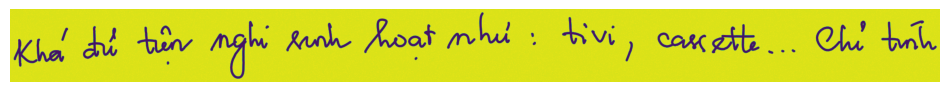

🔴 Ground Truth (Đúng):  khá đủ tiện nghi sinh hoạt như : tivi, cassette... chỉ tính
🔸 Baseline (Cũ):        kha’di tên nghị kinh hoạt mhủ: tivi, carrette... chủ tinh
✅ Fine-tune (Mới):      khá đủ tiền nghỉ kinh hoạt như : tivi, cơ sở... chủ tinh
____________________________________________________________________________________________________

--- MẪU NGẪU NHIÊN #214 ---


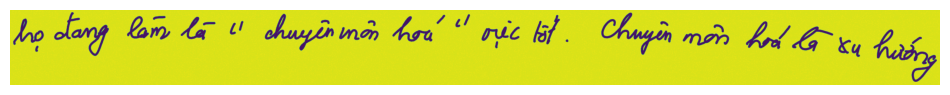

🔴 Ground Truth (Đúng):  họ đang làm là " chuyên môn hóa " việc tốt. chuyên môn hóa là xu hướng
🔸 Baseline (Cũ):        ho dong lam lai " chuyen man hoa" "riciet". chuyen man ho lai xu hong
✅ Fine-tune (Mới):      họ đang làm là " chuyển món hóa " " rực lét ". chuyên môn họ là xu hướng
____________________________________________________________________________________________________

--- MẪU NGẪU NHIÊN #67 ---


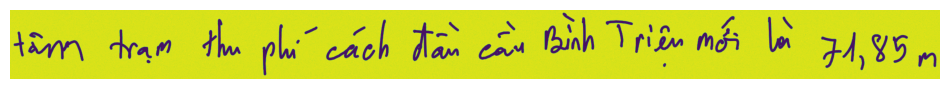

🔴 Ground Truth (Đúng):  tâm trạm thu phí cách đầu cầu bình triệu mới là 71,85 m.
🔸 Baseline (Cũ):        tam trao thu phu-ach tuan can binh trien moi lai 71,85 m
✅ Fine-tune (Mới):      tâm trạm thu phí cách đảo cầu bình triệu một lùi 71,85 m
____________________________________________________________________________________________________



In [19]:
import random
import matplotlib.pyplot as plt
from PIL import Image

baseline_total_cer = baseline_metrics.get('total_cer', 0)
baseline_total_wer = baseline_metrics.get('total_wer', 0)
baseline_mean_cer = baseline_metrics.get('mean_cer', 0)
baseline_median_cer = baseline_metrics.get('median_cer', 0)
baseline_min_cer = baseline_metrics.get('min_cer', 0)
baseline_max_cer = baseline_metrics.get('max_cer', 0)

print("\n" + "="*50)
print(" 📊 BẢNG TỔNG HỢP KẾT QUẢ SO SÁNH")
print("="*50)
print(f"{'Chỉ số':<20} | {'Baseline (%)':>12} | {'Fine-tuned (%)':>15}")
print("-" * 50)

print(f"{'Total CER':<20} | {baseline_total_cer*100:>11.2f} | {final_cer*100:>14.2f}")
print(f"{'Mean CER':<20} | {baseline_mean_cer*100:>11.2f} | {mean_cer_ft*100:>14.2f}")
print(f"{'Median CER':<20} | {baseline_median_cer*100:>11.2f} | {median_cer_ft*100:>14.2f}")
print(f"{'Min CER':<20} | {baseline_min_cer*100:>11.2f} | {min_cer_ft*100:>14.2f}")
print(f"{'Max CER':<20} | {baseline_max_cer*100:>11.2f} | {max_cer_ft*100:>14.2f}")
print("-" * 50)

print(f"{'Total WER':<20} | {baseline_total_wer*100:>11.2f} | {final_wer*100:>14.2f}")
print("=" * 50)

improvement_cer = baseline_total_cer - final_cer
improvement_wer = baseline_total_wer - final_wer
print(f"\n✅ CẢI THIỆN (Total CER): Giảm được {improvement_cer*100:.2f}% lỗi mức ký tự.")
print(f"✅ CẢI THIỆN (Total WER): Giảm được {improvement_wer*100:.2f}% lỗi mức từ.")
print("=" * 50 + "\n")


baseline_predictions = baseline_metrics['predictions']

indices = random.sample(range(len(test_set)), 3)

for i in indices:
    sample = test_set[i]
    print(f"--- MẪU NGẪU NHIÊN #{i} ---")

    plt.figure(figsize=(12, 3))
    try:
        img = Image.open(sample['image_path'])
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"[Lỗi không load được ảnh: {e}]")

    print(f"🔴 Ground Truth (Đúng):  {all_gts[i]}")
    print(f"🔸 Baseline (Cũ):        {baseline_predictions[i]}")
    print(f"✅ Fine-tune (Mới):      {all_preds[i]}")
    print("_"*100 + "\n")

### Saving, loading finetuned models

In [20]:
import os
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive đã được kết nối sẵn.")

save_path = "/content/drive/MyDrive/DeepSeek_OCR_Project/lora_model_finetuned"
if not os.path.exists(save_path):
    os.makedirs(save_path)

print(f"Đang lưu model vào: {save_path} ...")

model.save_pretrained(save_path)

tokenizer.save_pretrained(save_path)

print("ĐÃ LƯU THÀNH CÔNG! Kiểm tra Google Drive của bạn.")

Drive đã được kết nối sẵn.
Đang lưu model vào: /content/drive/MyDrive/DeepSeek_OCR_Project/lora_model_finetuned ...


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


ĐÃ LƯU THÀNH CÔNG! Kiểm tra Google Drive của bạn.


In [ ]:
# Khi cần dùng lại:
model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "/content/drive/MyDrive/DeepSeek_OCR_Project/lora_model_finetuned", # Đường dẫn đã lưu
    load_in_4bit = True,
    # ...
)
FastVisionModel.for_inference(model)